---
---
---
# CSC8635 Mini-projects
## Introduction

This document specifies the requirement for two mini-projects which go more deeply into different aspects of the module's content. You have to follow **ALL** of these requirements in both mini-projects. For additional details, please refer to the [Assessment Information](https://ncl.instructure.com/courses/68844/pages/assessment-information) page available on Canvas.

The learning objectives of this assignment are:
1. To learn about the design of machine learning analysis pipelines
2. To understand how to select appropriate methods given the dataset type
3. To learn how to conduct machine learning experimentation in a rigorous and effective manner
4. To critically evaluate the performance of the designed machine learning pipelines
5. To learn and practice the skills of reporting machine learning experiments

For this coursework you will be provided with two different datasets:
1. A tabular dataset, defined as a classification problem
2. A tabular dataset, defined as a regression problem

Your job is easy to state: You should design a range of machine learning pipelines appropriate to the nature of each dataset. Overall, we expect that you will perform a thorough investigation involving (whenever relevant) all parts of a machine learning pipeline (exploration, preprocessing, model training, model interpretation and evaluation), evaluating a range of options for all parts of the pipeline and with proper hyperparameter tuning.

You will have to write a short report (within this notebook) that presents the experiments you did, their justification, a detailed description of the performance of your designed pipelines using the most appropriate presentation tools (e.g., tables of results, plots). We expect that you should be able to present your work at a level of detail that would enable a fellow student to reproduce your steps.

## Deliverables
An inline report and code blocks addressing the marking scheme below. The report is expected to have 1000 to 2000 words. The word count excludes references, tables, figures, code blocks and section headers, and has a 10% leeway.

## Marking scheme

- Dataset exploration: 10 marks
- Methods: 30 marks
- Results of analysis: 30 marks
- Discussion: 20 marks
- Presentation (Writing Style, references, figures, etc.): 10 marks

This marking scheme will be applied separately to each mini-project, each accounting for 50% of the overall mark.

Some help for good marks:
- Split your work up into separate code blocks to help the reader understand what you have done.
- Provide text blocks, between code blocks, which help expalin what your code blocks are doing.
- It's not just about applying the first pipeline you find and using default hyperparameters but trying different pipelines and optimising the hyperparameters.
- We expect the solutions that you use to be based on the machine learning techniques you have been taught in the lectures/practicals.
- Note there are marks for presentation, so think about this both for the code, outputs and text you write.

---
---
## Dataset 1: Classification

The dataset, called FARS, is a collection of statistics of US road traffic accidents. The class label (target variable) is about the severity of the accident. It has 20 features and over 100K examples. The dataset can be found in Canvas as a CSV file ("fars.csv"), located alongside this notebook, in which the last column contains the class labels.

## What you need to do:

You will need to perform the following steps on the dataset:
1. EDA
2. Data preprocessing
3. Split the data into training and test sets using cross-validation
4. Develop **FOUR** machine learning pipelines for classifying the severity of the accident
5. Present the results for your pipeline using the most appropriate set of metrics.
6. Provide a short report on which approaches you used and which gave the best results. It would be good to consider why particular pipelines gave the best results.

Some help for good marks:
- We expect that you evaluate a very broad range of options for the design of your machine learning pipelines, including (but not limited to) data preprocessing, feature/instance selection, class imbalance correction, several (appropriate) machine learning pipelines and hyperparameter tuning.


## Your answer below

### Exploratory Data Analysis (EDA)

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

c:\Users\fauzi\OneDrive - Newcastle University\Courses\Term 1\Machine Learning CSC8635\ml_csc8635\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
df_fars = pd.read_csv('fars.csv')

# Generate Report
# 'minimal=True' bisa dipakai kalau laptop terasa berat/lambat karena data besar
profile = ProfileReport(df_fars, title="FARS Dataset EDA Report", explorative=True)

# Save Report to HTML file
profile.to_file("Laporan_EDA.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 173.45it/s]


In [3]:
# 1 Remove Duplicates

# Check for duplicates
initial_rows = df_fars.shape[0]
duplicates = df_fars.duplicated().sum()

print(f"Jumlah baris awal: {initial_rows}")
print(f"Jumlah duplikat ditemukan: {duplicates}")

if duplicates > 0:
    # Remove duplicates (keep='first' means keep the first occurrence, drop the rest)
    df_fars = df_fars.drop_duplicates(keep='first')
    current_rows = df_fars.shape[0]
    print(f"Duplicates removed. Current number of rows: {current_rows}")
    print(f"Total rows dropped: {initial_rows - current_rows}")
else:
    print("No duplicates found. Data is clean.")

Jumlah baris awal: 100968
Jumlah duplikat ditemukan: 7964
Duplicates removed. Current number of rows: 93004
Total rows dropped: 7964


### Preprocessing

In [4]:
# 1 Target Variable Engineering - 3 Classes

def categorize_severity(val):
    # Fatal Injury
    if val == 'Fatal_Injury':
        return 'Fatal'
    
    # Serious Injury
    elif val == 'Incapaciting_Injury':
        return 'Serious'
    
    # Minor Injury
    elif val in ['No_Injury', 'Nonincapaciting_Evident_Injury', 'Possible_Injury']:
        return 'Minor'
    
    # Missing or Other
    else:
        return np.nan

# Function Apply
df_fars['Target'] = df_fars['INJURY_SEVERITY'].apply(categorize_severity)

# Drop rows with NaN
df_clean = df_fars.dropna(subset=['Target']).copy()

# Check New Distribution
print("=== TARGET DISTRIBUTION 3 CLASSES ===")
counts = df_clean['Target'].value_counts().sort_index()
print(counts)
print("\n=== PERCENTAGE ===")
print(df_clean['Target'].value_counts(normalize=True).sort_index() * 100)

=== TARGET DISTRIBUTION 3 CLASSES ===
Target
Fatal      41442
Minor      36691
Serious    14230
Name: count, dtype: int64

=== PERCENTAGE ===
Target
Fatal      44.868616
Minor      39.724782
Serious    15.406602
Name: proportion, dtype: float64


C:\Users\fauzi\AppData\Local\Temp\ipykernel_39984\3667740613.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fars['Target'] = df_fars['INJURY_SEVERITY'].apply(categorize_severity)


In [5]:
# 2 Cleaning Age & Alcohol

# 1. Cleaning Age: Value 99 is a code for Unknown
df_clean['AGE'] = df_clean['AGE'].replace({99: np.nan})

# 2. Cleaning Alcohol: Values 96-99 are status codes (Refused/Not Given)
# We consider 0 (Not detected) to maintain ordinality
df_clean['ALCOHOL_TEST_RESULT'] = df_clean['ALCOHOL_TEST_RESULT'].apply(lambda x: 0 if x > 94 else x)

print("Statistics Age after cleaning:")
print(df_clean['AGE'].describe())
print("\nStatistics Alcohol after cleaning:")
print(df_clean['ALCOHOL_TEST_RESULT'].describe())

Statistics Age after cleaning:
count    91438.000000
mean        35.821868
std         20.217750
min          0.000000
25%         20.000000
50%         32.000000
75%         48.000000
max         97.000000
Name: AGE, dtype: float64

Statistics Alcohol after cleaning:
count    92363.000000
mean         2.095731
std          6.280829
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         81.000000
Name: ALCOHOL_TEST_RESULT, dtype: float64


In [6]:
# 3 Categorical Simplification

# A. Seat Position (26 categories to 4 general categories)
def simplify_seating(val):
    val = str(val).lower()
    if 'driver' in val: return 'Driver'
    if 'front' in val: return 'Front_Passenger'
    if 'back' in val or 'rear' in val or 'second' in val or 'third' in val: return 'Back_Passenger'
    return 'Other'

df_clean['SEATING_SIMPLE'] = df_clean['SEATING_POSITION'].apply(simplify_seating)

# B. Seatbelt (Simplify belt types)
def simplify_restraint(val):
    val = str(val).lower()
    if 'none' in val or 'no' in val: return 'None'
    if 'belt' in val: return 'Seatbelt'
    if 'helmet' in val: return 'Helmet'
    return 'Other'

df_clean['RESTRAINT_SIMPLE'] = df_clean['RESTRAINT_SYSTEM-USE'].apply(simplify_restraint)

# C. Airbag (Deployed vs Not)
def simplify_airbag(val):
    val = str(val).lower()
    if 'deployed' in val: return 'Deployed'
    if 'not available' in val: return 'Not_Available'
    return 'Not_Deployed'

df_clean['AIRBAG_SIMPLE'] = df_clean['AIR_BAG_AVAILABILITY/DEPLOYMENT'].apply(simplify_airbag)

# D. Person Type (10 categories -> 3 Categories)
def simplify_person(val):
    val = str(val).lower()
    
    # Group 1: Driver
    if 'driver' in val: 
        return 'Driver'
    
    # Group 2: Non-Motorist (Pedestrians & Cyclists)
    # This is the most vulnerable group (Vulnerable Road Users)
    elif 'pedestrian' in val or 'cyclist' in val or 'bicyclist' in val or 'non-motorist' in val or 'non-motor' in val:
        return 'Non_Motorist'
    
    # Group 3: Passenger
    # Includes 'occupant'
    elif 'passenger' in val or 'occupant' in val:
        return 'Passenger'
    
    # Others: Unknown (become NaN)
    else:
        return np.nan

# Apply
df_clean['PERSON_TYPE_SIMPLE'] = df_clean['PERSON_TYPE'].apply(simplify_person)

# E. Non-Motorist Location (18 categories -> 3 Zones)
def simplify_location(val):
    val = str(val).lower()
    
    # Group 1: Vehicle Occupant (Majority)
    if 'vehicle_occupant' in val:
        return 'Vehicle'
    
    # Group 2: Intersection
    elif 'intersection' in val and 'non-intersection' not in val: 
        # Check 'non-intersection' not in val because there is a category 'Non-Intersection' with a similar name
        return 'Intersection'
    
    # Group 3: Non-Intersection (Straight Road / Shoulder / Others)
    elif 'non-intersection' in val:
        return 'Non_Intersection'
    
    # Other (Unknown) -> NaN
    else:
        return np.nan

# Apply
df_clean['LOC_SIMPLE'] = df_clean['NON_MOTORIST_LOCATION'].apply(simplify_location)

# F. Related Factor 1 (Take Top 15, others 'Other')
# The goal is to reduce the dimension from 45 columns to just 16 columns.
def simplify_related_factor(df_input, top_n=10):
    # Count the top 10 most frequent causes
    top_factors = df_input['RELATED_FACTOR_(1)-PERSON_LEVEL'].value_counts().nlargest(top_n).index.tolist()
    
    # Function to check: If in Top 10, keep it. If not, replace with 'Other'.
    def apply_threshold(val):
        if val in top_factors:
            return val
        else:
            return 'Other_Factor'
            
    return df_input['RELATED_FACTOR_(1)-PERSON_LEVEL'].apply(apply_threshold)

# Apply
df_clean['FACTOR_SIMPLE'] = simplify_related_factor(df_clean, top_n=10)

# Check Unique Values after Simplification
print("Unique Seating Positions:", df_clean['SEATING_SIMPLE'].unique())
print("Unique Restraint Systems:", df_clean['RESTRAINT_SIMPLE'].unique())
print("Unique Airbag Status:", df_clean['AIRBAG_SIMPLE'].unique())
print("Unique Person Types:", df_clean['PERSON_TYPE_SIMPLE'].unique())
print("Unique Non-Motorist Locations:", df_clean['LOC_SIMPLE'].unique())
print("Unique Related Factors:", df_clean['FACTOR_SIMPLE'].unique())

Unique Seating Positions: ['Driver' 'Front_Passenger' 'Other' 'Back_Passenger']
Unique Restraint Systems: ['None' 'Seatbelt' 'Helmet' 'Other']
Unique Airbag Status: ['Deployed' 'Not_Deployed']
Unique Person Types: ['Driver' 'Passenger' 'Non_Motorist']
Unique Non-Motorist Locations: ['Vehicle' 'Non_Intersection' 'Intersection' nan]
Unique Related Factors: ['Not_Applicable_-_Driver/None_-_All_Other_Persons'
 'Walking/Riding_with_or_Against_Traffic_Playing_Working_Sitting_Lying_Standing_etc._in_Roadway'
 'Improper_Crossing_or_Roadway_or_Intersection' 'Unknown'
 'Darting_Stumbling_or_Running_into_Road' 'Other_Factor'
 'Failure_to_Yield_Right_of_Way' 'Not_Visible'
 'Failure_to_Obey_Traffic_Signs_Traffic_Control_Devices_or_Traffic_Officers_Failure_to_Observe_Safety_Zone_Traffic_Laws'
 'Inattentive_(talking_Eating_etc)' 'Interfering_with_Driver']


In [7]:
# 4.1 Cleaning "Unknown" in Categorical Columns

# List of variations indicating 'Unknown'
unknown_variations = [
    'Unknown', 
    'Not_reported',
    'Unknown_(Police_Reported)'
]

# Replace unknown variations with NaN
df_clean = df_clean.replace(unknown_variations, np.nan)


In [8]:
# 4 Create Drug Flag

drug_cols = ['DRUG_TEST_RESULTS_(1_of_3)', 'DRUG_TEST_RESULTS_(2_of_3)', 'DRUG_TEST_RESULTS_(3_of_3)']

def check_drug(row):
    # Check in the three columns if there is a value > 0 (Positive) but < 900 (Not an Error Code)
    for col in drug_cols:
        val = row[col]
        if val > 0 and val < 900: 
            return 'Yes'
    return 'No'

df_clean['DRUG_INVOLVED_BY_TEST'] = df_clean.apply(check_drug, axis=1)

print("Proportion of Drug Involvement:")
print(df_clean['DRUG_INVOLVED_BY_TEST'].value_counts(normalize=True))

Proportion of Drug Involvement:
DRUG_INVOLVED_BY_TEST
No     0.813313
Yes    0.186687
Name: proportion, dtype: float64


In [9]:
# 5 Drop Leakage & Redundant Columns

cols_to_drop = [
    'INJURY_SEVERITY', # Target Asli
    
    # --- CRITICAL: DATA LEAKAGE ---
    'RACE', 'HISPANIC_ORIGIN',      # Bias pencatatan (Bocoran jawaban)
    'TAKEN_TO_HOSPITAL',            # Future information (terjadi setelah kecelakaan)
    'EXTRICATION',                  # Future information
    
    # --- REDUNDANT / TECHNICAL ---
    'SEATING_POSITION',             # Replaced by SEATING_SIMPLE
    'RESTRAINT_SYSTEM-USE',         # Replaced by RESTRAINT_SIMPLE
    'AIR_BAG_AVAILABILITY/DEPLOYMENT', # Replaced by AIRBAG_SIMPLE
    'PERSON_TYPE',                  # Replaced by PERSON_TYPE_SIMPLE
    'NON_MOTORIST_LOCATION',    # Replaced by LOC_SIMPLE
    'EJECTION_PATH',                # Redundant with EJECTION
    'METHOD_ALCOHOL_DETERMINATION', 'ALCOHOL_TEST_TYPE', # Technical noise
    'METHOD_OF_DRUG_DETERMINATION', 'POLICE-REPORTED_DRUG_INVOLVEMENT', # Technical noise
    'DRUG_TEST_RESULTS_(1_of_3)', 'DRUG_TEST_RESULTS_(2_of_3)', 'DRUG_TEST_RESULTS_(3_of_3)',
    'DRUG_TEST_TYPE_(1_of_3)', 'DRUG_TEST_TYPE_(2_of_3)', 'DRUG_TEST_TYPE_(3_of_3)',
    #'RELATED_FACTOR_(2)-PERSON_LEVEL', 'RELATED_FACTOR_(3)-PERSON_LEVEL' # High cardinality
    'RELATED_FACTOR_(1)-PERSON_LEVEL', # <--- DROP THE ORIGINAL
    'RELATED_FACTOR_(2)-PERSON_LEVEL', # DROP (Sparsity)
    'RELATED_FACTOR_(3)-PERSON_LEVEL' # DROP (Sparsity)
]

df_final = df_clean.drop(columns=cols_to_drop, errors='ignore')

print(f"Final Shape: {df_final.shape}")
print("Final Columns:", df_final.columns.tolist())

df_final.head()

Final Shape: (92363, 14)
Final Columns: ['CASE_STATE', 'AGE', 'SEX', 'EJECTION', 'POLICE_REPORTED_ALCOHOL_INVOLVEMENT', 'ALCOHOL_TEST_RESULT', 'Target', 'SEATING_SIMPLE', 'RESTRAINT_SIMPLE', 'AIRBAG_SIMPLE', 'PERSON_TYPE_SIMPLE', 'LOC_SIMPLE', 'FACTOR_SIMPLE', 'DRUG_INVOLVED_BY_TEST']


,CASE_STATE,AGE,SEX,EJECTION,POLICE_REPORTED_ALCOHOL_INVOLVEMENT,ALCOHOL_TEST_RESULT,Target,SEATING_SIMPLE,RESTRAINT_SIMPLE,AIRBAG_SIMPLE,PERSON_TYPE_SIMPLE,LOC_SIMPLE,FACTOR_SIMPLE,DRUG_INVOLVED_BY_TEST
0,Alabama,34.0,Male,Totally_Ejected,Yes_(Alcohol_Involved),0,Fatal,Driver,None,Deployed,Driver,Vehicle,Not_Applicable_-_Driver/None_-_All_Other_Persons,No
1,Alabama,20.0,Male,Totally_Ejected,No_(Alcohol_Not_Involved),0,Fatal,Driver,None,Deployed,Driver,Vehicle,Not_Applicable_-_Driver/None_-_All_Other_Persons,No
2,Alabama,43.0,Male,Not_Ejected,No_(Alcohol_Not_Involved),0,Fatal,Driver,Seatbelt,Not_Deployed,Driver,Vehicle,Not_Applicable_-_Driver/None_-_All_Other_Persons,No
3,Alabama,38.0,Female,Not_Ejected,NaN,0,Serious,Front_Passenger,Seatbelt,Not_Deployed,Passenger,Vehicle,Not_Applicable_-_Driver/None_-_All_Other_Persons,No
4,Alabama,50.0,Male,Not_Ejected,Yes_(Alcohol_Involved),0,Fatal,Driver,Seatbelt,Deployed,Driver,Vehicle,Not_Applicable_-_Driver/None_-_All_Other_Persons,No


In [10]:
profile = ProfileReport(df_final, title="Final EDA Report", explorative=True)

# Save Report to HTML file
profile.to_file("Laporan_Final_EDA.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 341.22it/s]


In [11]:
# 7 Train-Test Split with Stratification

# 1. Split Features & Target
X = df_final.drop(columns=['Target'])
y = df_final['Target']

# 2. Train-Test Split
# define stratify=y for imbalanced datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 3. Verify Dimensions
print(f"Training Set Dimension: {X_train.shape}")
print(f"Test Set Dimension    : {X_test.shape}")

# 4. Check Class Proportions
print("\nClass Proportions in Training Set:")
print(y_train.value_counts(normalize=True))

Training Set Dimension: (73890, 13)
Test Set Dimension    : (18473, 13)

Class Proportions in Training Set:
Target
Fatal      0.448680
Minor      0.397253
Serious    0.154067
Name: proportion, dtype: float64


In [12]:
# 8 Define Preprocessing Transformers

# Automatically detect columns based on data type in X_train
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric Features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")

# Numeric Transformer: Median Imputation -> Standard Scaling
num_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer: Mode Imputation -> OneHot Encoding
cat_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Ignore new categories appearing in test
])

# Combine both
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ])

print("preprocessor setup done")

Numeric Features (2): ['AGE', 'ALCOHOL_TEST_RESULT']
Categorical Features (11): ['CASE_STATE', 'SEX', 'EJECTION', 'POLICE_REPORTED_ALCOHOL_INVOLVEMENT', 'SEATING_SIMPLE', 'RESTRAINT_SIMPLE', 'AIRBAG_SIMPLE', 'PERSON_TYPE_SIMPLE', 'LOC_SIMPLE', 'FACTOR_SIMPLE', 'DRUG_INVOLVED_BY_TEST']
preprocessor setup done


In [13]:
# --- PIPELINE 1: LogReg + Selection + UnderSampling ---
pipeline_1 = ImbPipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)), # Select 10 best features
    ('undersampler', RandomUnderSampler(sampling_strategy='majority', random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# --- PIPELINE 2: LogReg + All Features + SMOTE ---
pipeline_2 = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# --- PIPELINE 3: Random Forest + Weighted + RF Selection ---
pipeline_3 = ImbPipeline([
    ('preprocessor', preprocessor),
    # Small RF to select important features
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=42))), 
    # Class weight 'balanced' replaces the role of SMOTE
    #('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ('classifier', RandomForestClassifier(n_estimators=100, 
                                          class_weight='balanced_subsample', 
                                          max_depth=10, 
                                          min_samples_split=5, 
                                          min_samples_leaf=1, 
                                          random_state=42)) 
])

#Best Params: {'classifier__n_estimators': 100, 
# 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 
# 'classifier__max_depth': 10, 'classifier__class_weight': 'balanced_subsample'}

# --- PIPELINE 4: Random Forest + SMOTE (All Features) ---
pipeline_4 = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Collect in a list for easy looping
pipelines = [pipeline_1, pipeline_2, pipeline_3, pipeline_4]
pipeline_names = ["P1: LogReg+Under", "P2: LogReg+SMOTE", "P3: RF+Weighted", "P4: RF+SMOTE"]

print("done pipelines setup")

done pipelines setup


In [14]:
# 10 Run Stratified Cross-Validation

from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

# List for storing scores and times
results = []
names = []
times = []

# Metric: F1 Macro (Most fair for Imbalanced Multiclass)
scoring_metric = 'f1_macro'

print(f"Starting Training 4 Pipelines with 5-Fold CV...")
print(f"Evaluation Metric: {scoring_metric}\n")
print("-" * 60)
print(f"{'Pipeline Name':<20} | {'Mean Score':<10} | {'Std Dev':<10} | {'Time (s)':<10}")
print("-" * 60)

for name, model in zip(pipeline_names, pipelines):
    start_time = time.time()
    
    # StratifiedKFold ensures balanced proportions of Fatal/Serious/Minor classes in each fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Run CV (n_jobs=-1 uses all CPU cores for speed)
    cv_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring_metric, n_jobs=-1)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # Save results
    results.append(cv_results)
    names.append(name)
    times.append(duration)
    
    print(f"{name:<20} | {cv_results.mean():.4f}     | +/-{cv_results.std():.4f}   | {duration:.2f} s")

print("-" * 60)

Starting Training 4 Pipelines with 5-Fold CV...
Evaluation Metric: f1_macro

------------------------------------------------------------
Pipeline Name        | Mean Score | Std Dev    | Time (s)  
------------------------------------------------------------
P1: LogReg+Under     | 0.4835     | +/-0.0040   | 3.38 s
P2: LogReg+SMOTE     | 0.5700     | +/-0.0032   | 31.08 s
P3: RF+Weighted      | 0.5503     | +/-0.0089   | 65.94 s
P4: RF+SMOTE         | 0.5176     | +/-0.0033   | 229.98 s
------------------------------------------------------------


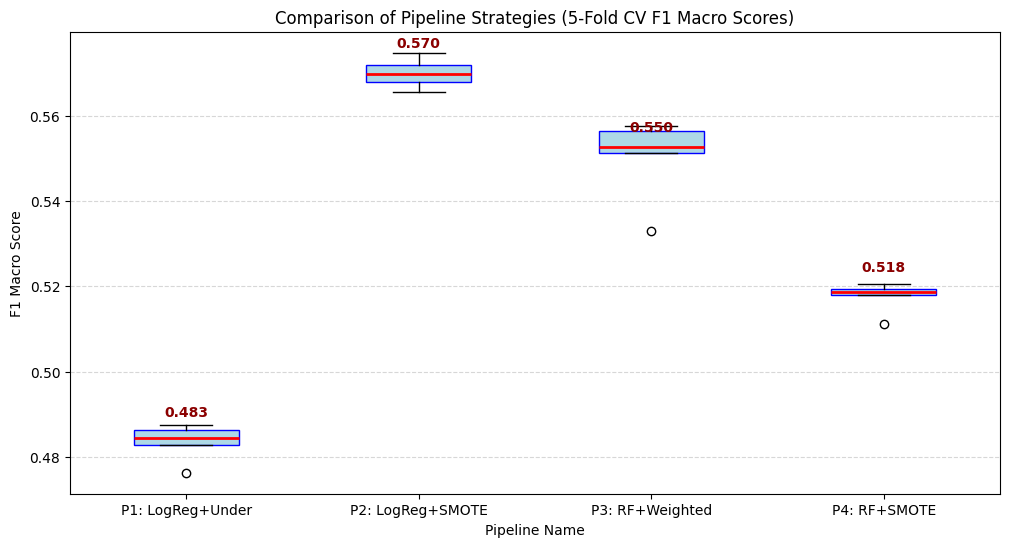

In [15]:
# 11 Compare Algorithms (Boxplot)

plt.figure(figsize=(12, 6))

# Make boxplot
plt.boxplot(results, tick_labels=names, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2))

plt.title('Comparison of Pipeline Strategies (5-Fold CV F1 Macro Scores)')
plt.ylabel('F1 Macro Score')
plt.xlabel('Pipeline Name')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add mean value annotations
for i, result in enumerate(results):
    mean_val = result.mean()
    plt.text(i+1, mean_val + 0.006, f'{mean_val:.3f}', 
             horizontalalignment='center', color='darkred', fontweight='bold')

plt.show()

Detail Evaluation of P2: LogReg+SMOTE

Classification Report:
              precision    recall  f1-score   support

       Fatal       0.81      0.64      0.71      8289
       Minor       0.63      0.63      0.63      7338
     Serious       0.29      0.46      0.35      2846

    accuracy                           0.61     18473
   macro avg       0.58      0.58      0.57     18473
weighted avg       0.66      0.61      0.63     18473

[[4639 1935  764]
 [1049 1319  478]
 [1630 1372 5287]]


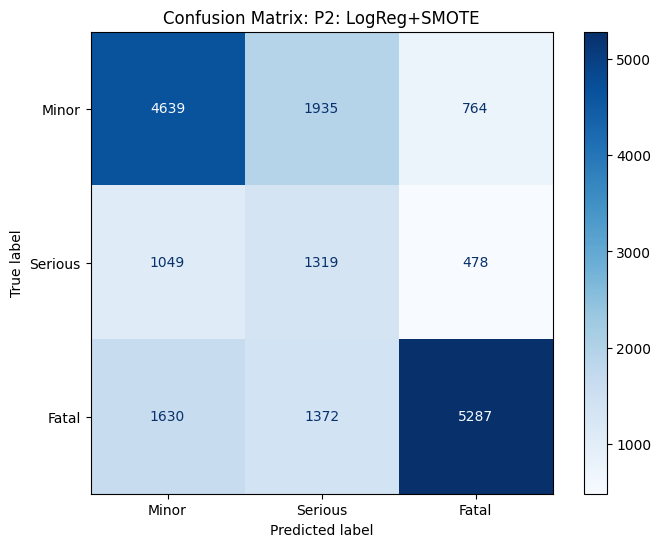

In [16]:
# 12 Final Evaluation on Test Set (Highest score: Pipeline 2)

# Choose P2 (Logistic Regression + SMOTE)
best_model = pipelines[1] # Index 1 adalah P2
best_name = pipeline_names[1]

print(f"Detail Evaluation of {best_name}")

# Retrain model with full training data 
best_model.fit(X_train, y_train)

# Predict on Test Set
y_pred = best_model.predict(X_test)

# 1. Print Detailed Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 2. Visualize Errors (Confusion Matrix)
# Label order: Minor -> Serious -> Fatal
labels_order = ['Minor', 'Serious', 'Fatal']

fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred, labels=labels_order)
print(cm)

# Plot Heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title(f'Confusion Matrix: {best_name}')
plt.show()

---
---
## Dataset 2: Regression

In this part of the coursework you are going to look at a regession problem - predicting the growth rate of a bacteria. The provided dataset contains results from a set of experiments where we grew bacteria of different strains and under different conditions (CO2 availability, light, etc..) to compute a growth curve for the bacteria - represented by the variables 'a', 'mu', 'tau' and 'a0'. Your job is to predict the results of the experiment - 'a', 'mu', 'tau' and 'a0' (these are the growth-rate parameters for the bacteria, but you don't need to understand the details to do the coursework).

The dataset is available in Canvas as a CSV file ("fitting-results.csv"), in the same location where you downloaded this notebook.

The CSV contains 9 fields as follows:

| variable | description |
|-----|------|
| n_cyanos | The number of Cyanobacteria available at the start |
| co2 | The amount of CO2 available |
| light | The amount of light available |
| SucRatio | How good the bacteria is at producing sucrose |
| Nsample | Experiment number |
| a | Maximum number of bacteria seen (Target variable) |
| mu | Growth rate of bacteria (Target variable) |
| tau | Time delay before bacteria starts growing (Target variable) |
| a0 | Initial level of bacteria (Target variable) |

## What you need to do:

You will need to perform the following steps on the dataset:
1. EDA
2. Data preprocessing
3. Split the data into train/test/validate
4. Develop **FOUR** machine learning pipelines for predicting 'a', 'mu', 'tau' and 'a0'. This should include hyperparameter tuning. Note: This is not four pipelines one for 'a' one for 'mu'... but four pipelines for 'a', four for 'mu'...
5. Present the results for your pipelines using the most appropriate set of metrics.
6. Provide a short report on which approaches you used and which gave the best results. It would be good to consider why particular pipelines gave the best results.

Some help for good marks:
- Make sure that when you predict 'a' you don't have 'mu', 'tau' or 'a0' in your features - this would make it very easy to predict but be compleatly wrong.
- Remember that this is a **regression** problem and use models that are appropriate for this.
- Hyperparameters can be crucial to get good results here.

## Your answer below